<a href="https://colab.research.google.com/github/anilozdemir/Bee-DCD/blob/main/notebooks/01_ESN_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get Bee-DCD Repo from GitHub
---

In [1]:
!git clone https://github.com/anilozdemir/Bee-DCD.git

Cloning into 'Bee-DCD'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 45 (delta 9), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (45/45), done.


## Install `btdm` module

In [2]:
%cd Bee-DCD/src

/content/Bee-DCD/src


In [3]:
!python setup.py develop

running develop
running egg_info
creating BTDM.egg-info
writing BTDM.egg-info/PKG-INFO
writing dependency_links to BTDM.egg-info/dependency_links.txt
writing top-level names to BTDM.egg-info/top_level.txt
writing manifest file 'BTDM.egg-info/SOURCES.txt'
writing manifest file 'BTDM.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/BTDM.egg-link (link to .)
Adding BTDM 1.0 to easy-install.pth file

Installed /content/Bee-DCD/src
Processing dependencies for BTDM==1.0
Finished processing dependencies for BTDM==1.0


# Using ESNs to Match HoneyBee and BumbleBee Performance

In [4]:
import pickle
import itertools

import numpy as np
from scipy import stats

import pandas as pd
from tqdm.notebook import trange, tqdm
from joblib import Parallel, delayed

from btdm.networks import ESN_Reservoir, softMax, NoiseLayer
from btdm.environments import DCD_ESN_SingleStep, DCD
from btdm.agents import DCD_Agent
from btdm.utils import rolling_sum

import torch

import matplotlib.pyplot as P
from matplotlib import style
import seaborn as sns
style.use('ggplot')
sns.set_context('talk',font_scale=1.4)
sns.set_style("ticks")

# Get the experiment Data

In [5]:
bb_mean = np.load('../notebooks/data/experiment-data.npz')['bb_mean']
bb_sem  = np.load('../notebooks/data/experiment-data.npz')['bb_sem']
hb_mean = np.load('../notebooks/data/experiment-data.npz')['hb_mean']
hb_sem  = np.load('../notebooks/data/experiment-data.npz')['hb_sem']

In [6]:
def plot(perf):
    mean = np.mean(perf, axis=0)
    sem  = stats.sem(perf, axis=0)
    nBins = len(mean)
    P.figure(figsize=(14,6))
    P.errorbar(range(nBins), hb_mean, yerr=hb_sem, c='gold' , lw=3, marker='o', ms=4, mew=5)
    P.errorbar(range(nBins), bb_mean, yerr=bb_sem, c='black', lw=3, marker='o', ms=4, mew=5)
    P.errorbar(range(nBins), mean   , yerr=sem   , c='blue' , lw=3, marker='o', ms=4, mew=5)
    P.legend(['honeybee', 'bumblebee', 'ESN'])    
    P.plot(range(nBins),[0.5]*nBins,ls='--',c='gray')
    P.xlim(-0.25,nBins-0.75)
    P.xticks(range(nBins), range(1,nBins+1));
    P.ylim(0.20,0.85)
    P.yticks(np.linspace(0.25,0.75,3));
    P.xlabel('bins')
    P.ylabel('performance')
    sns.despine(top=True, right=True)

# Optimise Model

In [7]:
env_dcd         = DCD() # env to get hiddenStates
env_fn          = DCD_ESN_SingleStep # env to use hiddenStates

nAgents         = 20

nHiddenLayer    = 0
hiddenLayerSize = 0
noise           = 0.05
lR              = 0.06 
quantile        = 0.9 
contexts        = np.array([[0.5,0], [0,0.5]])
env_dcd         = DCD(randomSeed = 1, contexts=contexts) # env to get hiddenStates
env_fn          = DCD_ESN_SingleStep # env to use hiddenStates

def runAgentParallel(rand):        
    # create a new ESN model
    model = ESN_Reservoir(env_dcd.observation_space.shape[0], env_dcd.action_space.n, nReservoir=1000, activation=torch.tanh, device='cpu', randomSeed = rand)
    # create a new DCD agent
    agent = DCD_Agent(env_dcd, env_fn, model, randomSeed = rand, contexts=contexts)
    # init agent (readout, threshold, optim, noise)
    agent.init_readout_threshold_optim(lR=lR, quantile=quantile, noise=noise, nHiddenLayer = nHiddenLayer, hiddenLayerSize = hiddenLayerSize, SPARCE=True, thrGrad=False)
    # train agent
    agent.train(nEpoch=30, silent=True)
    # evaluate agent
    agent.evaluate(nTrial=10, silent=True)
    # return results 
    return {'train': agent.df, 'test': agent.eval_df}
EXP = Parallel(n_jobs=min(20,nAgents),verbose=0)(delayed(runAgentParallel)(r) for r in range(nAgents))
OverallPerf = np.array([EXP[i]['train'].perf.to_numpy().reshape(-1,5).mean(axis=1) for i in range(nAgents)])

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Plot

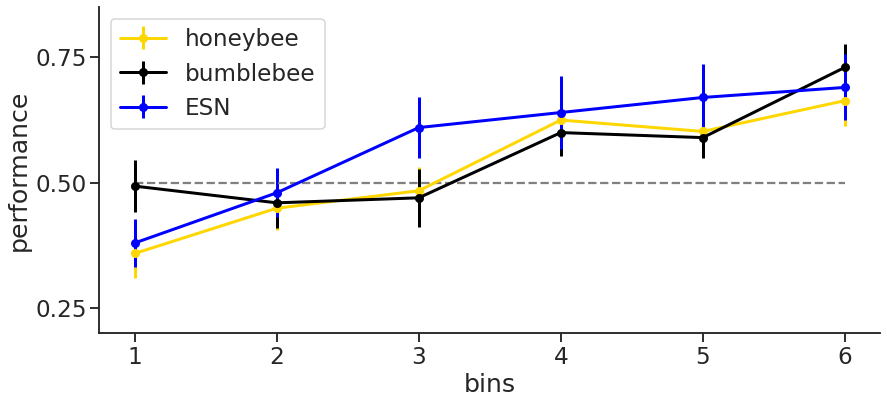

In [8]:
plot(OverallPerf)